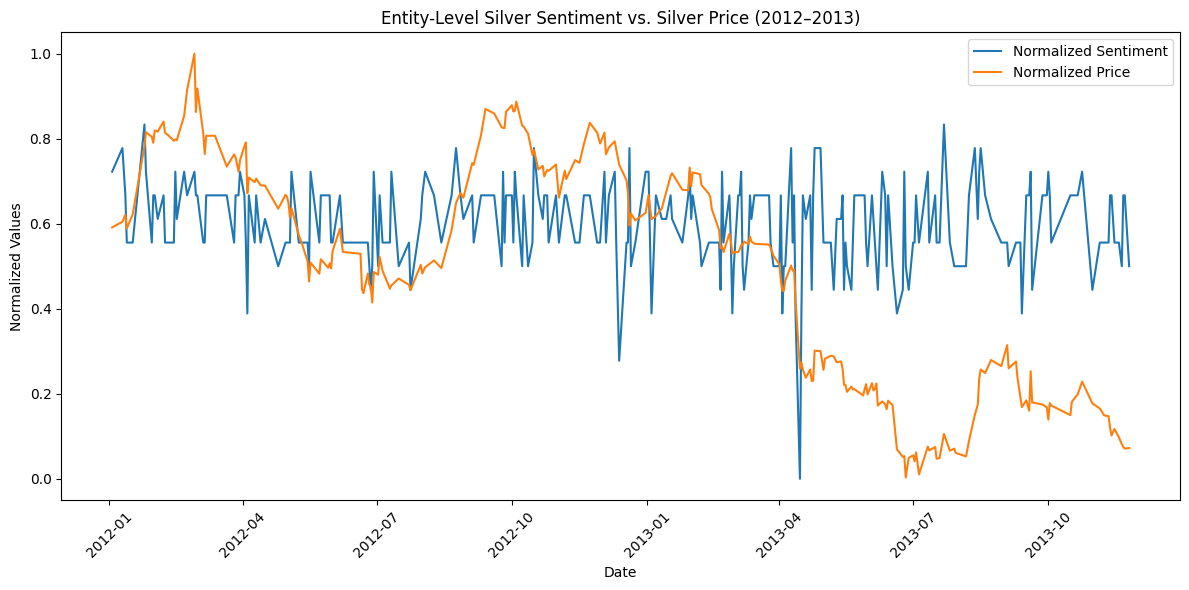

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
from datetime import datetime

# === Define related terms
TERMS = [
    'silver', 'silver prices', 'silver price', 'silver futures',
    'spot silver', 'silver market', 'silver demand', 'silver supply',
    'silver production', 'silver mining', 'silver bullion', 'silver bars',
    'silver coins', 'silver reserves', 'silver exports', 'silver imports',
    'silver ETF', 'precious metals', 'London Bullion Market', 'COMEX silver'
]




TITLE = "Entity-Level Silver Sentiment vs. Silver Price (2012–2013)"

# === Helper: Flexible date parser
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        return datetime.strptime(date_str, "%Y-%m-%d")

# === Load entity-level predictions
with open("entitylevel_predictions.json", "r", encoding="utf-8") as f:
    raw = json.load(f)


# === Aggregate sentiment per date
emotion_dict = {}

for item in raw:
    date_obj = parse_date(item["date"])
    date_key = date_obj.strftime("%Y-%m-%d")
    sentiment_score = 0
    for ent, sent in zip(item["entity"], item["sentiment"]):
        if ent.lower() in TERMS:
            if sent == "Positive":
                sentiment_score += 1
            elif sent == "Negative":
                sentiment_score -= 1
    if sentiment_score != 0:
        emotion_dict[date_key] = emotion_dict.get(date_key, 0) + sentiment_score

# === Normalize sentiment
emo_dates = sorted(emotion_dict.keys())
emo_vals = [emotion_dict[d] for d in emo_dates]
emo_arr = np.array(emo_vals).reshape(-1, 1)
emo_norm = MinMaxScaler().fit_transform(emo_arr).flatten()
emotion_series = pd.DataFrame({"date": pd.to_datetime(emo_dates), "norm_score": emo_norm})

# === Load cached price CSV
prices = pd.read_csv("cached_prices.csv")
prices["date"] = pd.to_datetime(prices["date"])

# Ensure correct column name
if "Close" in prices.columns and "price" not in prices.columns:
    prices.rename(columns={"Close": "price"}, inplace=True)

prices["price"] = pd.to_numeric(prices["price"], errors="coerce")

# === Filter to 2012–2013 and normalize
prices = prices[(prices["date"] >= "2012-01-01") & (prices["date"] <= "2013-12-31")]
prices["norm_price"] = MinMaxScaler().fit_transform(prices[["price"]])

# === Merge
merged = pd.merge(emotion_series, prices, on="date", how="inner").dropna()

# === Plot
plt.figure(figsize=(12, 6))
plt.plot(merged["date"], merged["norm_score"], label="Normalized Sentiment")
plt.plot(merged["date"], merged["norm_price"], label="Normalized Price")
plt.xlabel("Date")
plt.ylabel("Normalized Values")
plt.title(TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from minepy import MINE

mine = MINE(alpha=0.6, c=15, est="mic_approx")
mine.compute_score(merged["norm_score"], merged["norm_price"])
mic = mine.mic()

print(f"MIC (Max Information Coefficient): {mic:.3f}")